# Designing Transparent Neural Networks
> Generalized Linear and Additive Models are well-established interpretable approaches to supervised learning. This post connects these approaches to the building blocks of Neural Networks, and demonstrates that it's possible to design Neural Networks that are just as transparent!

- toc: true 
- badges: true
- comments: true
- categories: [transparency]
- image: images/nnflow.png
- show_description: false
- annotations: true
- show_tags: false
- title_abbrev: Designing Transparent Neural Nets

In [1]:
#hide
#necessary packages for the notebook
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#custom matplotlib stylesheet for the blog
plt.style.use('blog')

Most systems we interact with are part of some pipeline that integrates Machine Learning (ML). Sometimes we interact with an ML model directly, like Spotify's recommender system for songs. Other times, this interaction is more detatched; we post a comment on Twitter or Facebook, and this comment is used to train some language model at the respective company. As ML models become more and more prevalent, interpreting and explaining the decisions these models make become increasingly important. 

Neural networks are a popular class of machine learning algorithms, which are notorious for being difficult to interpret. They are often referred to as "black boxes" or "opaque". This blog post will explore a particular type of neural architecture that is inherrantly transparent. However, prior to jumping into that, it's important to understand the fundamental transparent algorithms, starting from the simplest linear models. The following section will provide a background on the math and fundamentals of linear and additive models, as well as how they relate to the inner mechanisms of neural networks{% fn 1 %}.

> note: If you are familiar the relationship between GLMs and NNs, feel free to skip this introductory section.

<p></p>

# Introducing Linear and Additive Models

Linear models are one of the simplest approaches to supervised learning. The general goal of supervised learning is to discover some function $f$ that minimizes an error-term $\epsilon$ given a set of input features $X$ and a corresponding target $y$ such that $y = f(X) + \epsilon$. Additionally, the output of a supervised model is often written as $\hat{y} = f(X)$ because $f(X)$ is our best approximation of $y$.

Different algorithms are sufficient for learning different functions. Simple linear models can only learn to make predictions according to functions of the form:

$$y = X^T\beta + \epsilon = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_n X_n + \epsilon$$

Where $\beta_i$ represents learned coefficients with respect to $X_i$, and $T$ is the transpose operation, which in this case is basically identical to computing the dot product of two n-dimensional vectors. 

## Linear Regression

Linear regression is arguably the simplest linear model, and comes with four assumptions:

1. **Linearity**: The relationship between $X$ and the mean of $y$ is linear.
2. **Independence**: $X_i$ and $X_j$ are linearly independent of eachother for all $i \neq j$.
3. **Normality**: $y$ given any $X$ comes from a normal distribution.
4. **Homoscedasticity**: The variance of the error is the same for any value of $X$.

These assumptions can be nicely described by one math equation:

$$
\begin{aligned}
y & \in \mathcal{N}(X^T\beta, \sigma^2 I) \\
& \Rightarrow \mathbb{E}[y|X] = \mu(X) = X^T\beta
\end{aligned}
$$

Unfortunately, these assumptions are quite rigid for the real world. Many datasets do not conform to these restrictions. So why do we still use linear regression when we have algorithms that can perform the regression task without such rigid assumptions? The common answers to this question are:

1. **Occam's Razor**: Don't add complexity without necessity.    
2. **Little Data**: Ordinary Least Squares (OLS) is a closed form solution to linear regression{% fn 2 %}.
3. **Interpretability**: $y$ can be explained with respect to how $X$ interacts with the $\beta$ coefficients.

Today, we are going to stick with the notion that transparency is of the utmost importance, and assume we have a significant amount of data. Whatever the model is, it must be able to produce feature-wise explanations that are useful. However, these models don't need to be exactly linear in order to be interpretable.

## Generalized Linear Models (GLMs)

Generalized Linear Model (GLM), introduced in {% cite GLM %}, loosen the constraints of normality, linearity, and homoscedasticity described in the previous section via the following specifications:

1. **Random Component**: The probability distribution of $y$ (typically belonging to the exponential family{% fn 3 %}).
2. **Systematic Component**: the right side of the equation for predicting $y$ (typically $X^T\beta$).
3. **Link Function**: A function $g$ that links the systematic component and the random component.

This yields the following general equation for GLMs:

$$g(\mathbb{E}[y|X]) = X^T\beta + \epsilon$$

Observe that if the random component is a normal distribution with a constant variance, and the link function is the identity function ($g(y) = y$), then the corresponding GLM is exactly linear regression! Hence, the functions that GLMs can describe are a superset of the functions linear regression can describe.

Selecting a link function according to the random component is what differentiates GLMs. The intuition behind a link function is that it transforms the distribution of $y$ to the range $(-\infty,+\infty)$, as that is the expected range of $X^T\beta$. As an example, binary logistic regression assumes the probability distribution of $y$ is a bernoulli distribution. This means that the average of the distribution, $\mu$, is between 0 and 1. We need some function $g: [0,1] \rightarrow \Reals$, and the logit function is sufficient for this:

$$g(\mu) = log(\frac{\mu}{1 - \mu})$$

Now, we can fit a simple linear model to $g(y) = X^T\beta + \epsilon$. Unfortunately, introducing a non-linear transformation to this equation means that Ordinary Least Squares is no longer a reasonable estimation method. Hence, learning $\beta$ requires a different estimation method. Maximum Likelihood Estimation (MLE) estimates the parameters of a probability distribution by maximizing the likelihood that a sample of observed data belongs to that probability distribution. In fact, under the assumptions of simple linear regression, MLE is equivalent to OLS as demonstrated on page 2 of [these CMU lecture notes](https://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/06/lecture-06.pdf). The specifics of MLE are not necessary for the rest of this blog post, however if you would like to learn more about it, please refer to [these Stanford lecture notes](http://web.stanford.edu/class/archive/cs/cs109/cs109.1202/lectureNotes/LN21_parameters_mle.pdf).

## The Building Blocks of Neural Networks

But where do neural networks come in? Aren't they incredibly non-linear and opaque, unlike GLMs? Sort of. On the macro-level, NNs and GLMs look very different, but the micro-level tells a different story. Let's zoom into the inner workings of neural networks and see how they relate to GLMs!

Neural networks are built of components called layers. Layers are built of components called nodes. At their heart, these nodes are computational-message-passing-machines. They receive a set of inputs, perform a computation, and pass the result of that computation to other nodes in the network. These are the building blocks of neural networks.

The first layer of a neural network is called the input layer, because each node passes an input feature to all nodes in the next layer. The last layer of a neural network is called the output layer, and it should represent the output you are trying to predict (this layer has one node in the classic regression case). Lastly, any layers between the input and output layers are called hidden layers.

![](https://ryansaxe.com/images/nnonelayer.png)

In the classic fully-connected feed-forwad neural network, this structure of layers is ordered and connected such that every node $n_j$ in layer $L_i$ receives the output of every node in the predecing layer $L_{i-1}$, does some computation with those outputs, and passes the corresponding output to each node in the succeeding layer $L_{i + 1}$. The image above displays a neural network with $N$ input features, a single hidden layer, and a single output prediction $\hat{y}$.

Each node in layer $L_i$ contains some set of weights ($w$) and a bias ($b$), where the dimension of the weight vector is equal to the number of nodes in layer $L_{i - 1}$. When the node receives the output of all the nodes in the preceding layer, it performs the following computation: $L_{i - 1}^Tw + b$. 

This should look familiar! It is quite literally $X^T\beta$: the classic computation from linear models on the ouputs of the preceding layer!

However, before this node passes $X^T\beta$ to the next layer in the network, it is passed through an activation function $f$. Activation functions often introduce non-linearity to the neural network, similar to link functions in GLMs. The image below isolates a single neuron from the image above, taking input from the previous layer, and making a prediction by transforming the output of the neuron with an activation function $\hat{y} = f(X^T\beta)$.

![](https://ryansaxe.com/images/nnflow.png) 

In fact, observe that if the activation function is invertible, this computation is equivalent to $f^{-1}(\hat{y}) = X^T\beta$, which is exactly a GLM with link function $f^{-1}$. This demonstrates that **the computation of a single node in a neural network is, conceptually, a GLM on the output of the previous layer!**

Furthermore, this means that a neural network with zero hidden layers and a linear activation function on the output layer is exactly equivalent to linear regression, as the lack of hidden layers maintains independence. And, if we change the activation function to the inverse of the logit function (this is the sigmoid activation function), this neural network becomes exactly equivalent to logistic regression! The code below is a simple prototype of building linear and logistic regression with [Keras](https://www.keras.io), and tests it on a simulated dataset.

In [2]:
#hide
#set up parameters to generate 3 normally distributed columns
columns = list('abc')
beta = [1, 1, 1]
bias = 0.0
size = 100000
mean = 5.0
std = 1.0
#create the dataset
data = {
    col: np.random.normal(
        size=size, loc=mean, scale=std
    ) for col in columns
}
X = pd.DataFrame(data)
betaX = X.copy()
for i,col in enumerate(columns):
    betaX[col] = X[col] * beta[i]
y_logistic = ((bias + betaX.sum(1)) > betaX.sum(1).mean()).astype(float)
y_linear = bias + betaX.sum(1)
#X.assign(target=y).head()

In [3]:
class LinearRegression(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # zero hidden layers with a linear activation on one output node
        self.output_layer = tf.keras.layers.Dense(1, activation='linear')
    
    def call(self, input_layer, training=None):
        return self.output_layer(input_layer)
    
class LogisticRegression(tf.keras.Model):
    def __init__(self):
        super().__init__()
        # zero hidden layers with a sigmoid activation on one output node
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid')
    
    def call(self, input_layer, training=None):
        return self.output_layer(input_layer)

In [4]:
#hide
#logistic regression setup
logistic_reg = LogisticRegression()
logistic_reg.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['mean_absolute_error']
)
hist = logistic_reg.fit(
    X.to_numpy(),
    y_logistic.to_numpy(),
    epochs=20,
    batch_size=32,
)

Train on 100000 samples
Epoch 1/20
100000/100000 [==============================] - 4s 45us/sample - loss: 0.7997 - mean_absolute_error: 0.4945
Epoch 2/20
100000/100000 [==============================] - 3s 32us/sample - loss: 0.6384 - mean_absolute_error: 0.4658
Epoch 3/20
100000/100000 [==============================] - 3s 31us/sample - loss: 0.5817 - mean_absolute_error: 0.4379
Epoch 4/20
100000/100000 [==============================] - 3s 32us/sample - loss: 0.5385 - mean_absolute_error: 0.4120
Epoch 5/20
100000/100000 [==============================] - 3s 32us/sample - loss: 0.5010 - mean_absolute_error: 0.3884
Epoch 6/20
100000/100000 [==============================] - 3s 32us/sample - loss: 0.4683 - mean_absolute_error: 0.3669
Epoch 7/20
100000/100000 [==============================] - 3s 32us/sample - loss: 0.4400 - mean_absolute_error: 0.3476
Epoch 8/20
100000/100000 [==============================] - 3s 32us/sample - loss: 0.4157 - mean_absolute_error: 0.3307
Epoch 9/20
10000

In [5]:
#hide
print('binary crossentropy loss:',round(hist.history['loss'][-1],3),'\nmean absolute error:',round(hist.history['mean_absolute_error'][-1],3))

binary crossentropy loss: 0.264 
mean absolute error: 0.217


In [6]:
#hide
#linear regression setup
linear_reg = LinearRegression()
linear_reg.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)
hist = linear_reg.fit(
    X.to_numpy(),
    y_linear.to_numpy(),
    epochs=20,
    batch_size=32,
)

Train on 100000 samples
Epoch 1/20
100000/100000 [==============================] - 3s 34us/sample - loss: 1.8801 - mean_absolute_error: 0.7894
Epoch 2/20
100000/100000 [==============================] - 3s 30us/sample - loss: 0.0372 - mean_absolute_error: 0.1323
Epoch 3/20
100000/100000 [==============================] - 3s 30us/sample - loss: 7.1706e-04 - mean_absolute_error: 0.0207
Epoch 4/20
100000/100000 [==============================] - 3s 30us/sample - loss: 4.6694e-05 - mean_absolute_error: 0.0042
Epoch 5/20
100000/100000 [==============================] - 3s 30us/sample - loss: 3.7388e-09 - mean_absolute_error: 2.2092e-05
Epoch 6/20
100000/100000 [==============================] - 3s 30us/sample - loss: 9.2843e-08 - mean_absolute_error: 9.4897e-05
Epoch 7/20
100000/100000 [==============================] - 3s 30us/sample - loss: 1.9630e-07 - mean_absolute_error: 1.9729e-04
Epoch 8/20
100000/100000 [==============================] - 3s 30us/sample - loss: 2.1271e-07 - mean_abs

In [7]:
#hide
print('mean squared error:',round(hist.history['loss'][-1],3),'\nmean absolute error:',round(hist.history['mean_absolute_error'][-1],3))

mean squared error: 0.0 
mean absolute error: 0.0


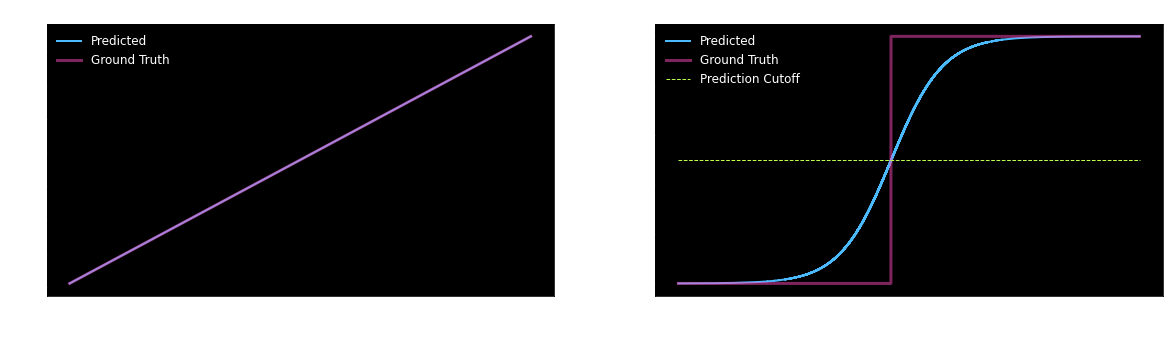

In [8]:
#hide_input
fig, axes = plt.subplots(1, 2)

X['target'] = betaX.sum(1)
x_sorted = X.sort_values(by='target')
y_before_label = bias + x_sorted['target']
test_y = (y_before_label > x_sorted['target'].mean()).astype(float).to_numpy()
test_X = x_sorted[columns].to_numpy(dtype=np.float32)

axes[0].plot(y_before_label, linear_reg(test_X), label="Predicted", lw=2)
axes[0].plot(y_before_label,y_before_label,label="Ground Truth", alpha=0.5)
axes[0].legend()
axes[0].set_title('Basic Linear Regression')
axes[0].set_xlabel('Sum of input features', c='white')
axes[0].set_ylabel('Target feature', c='white')

axes[1].plot(y_before_label, logistic_reg(test_X), label="Predicted", lw=2)
axes[1].plot(y_before_label,test_y,label="Ground Truth", alpha=0.5)
axes[1].plot([y_before_label.min(),y_before_label.max()], [0.5, 0.5], ls="--", lw=1, label="Prediction Cutoff")
axes[1].legend()
axes[1].set_title('Basic Logistic Regression')
axes[1].set_xlabel('Sum of input features', c='white')
axes[1].set_ylabel('Target feature', c='white')
plt.show()

However, It isn't always as simple as the cases of linear and logistic regression. Not all activation functions are invertible (e.g. ReLU), and hence add non-linearities in ways that are not consistent with GLMs. At the same time, the principal of the link function is to transform $y$ to the proper space, and ReLU does accomplish this under the assumption that $y$ cannot be negative.

There is clearly an intimate connection between neural networks and linear models, as the computational components of neural networks are quite literally non-linear transforms on linear models just like GLMs. So, why are neural networks opaque and GLMs transparent? Let's look at the math for regression using an arbitrarily defined neural network with $k$ hidden layers.

$$
\begin{aligned}
L_0& = \big [ X_1, X_2, \cdots, X_n \big ] \\
L_1 & = \big [\hspace{0.5em}f_1(L_0^Tw_{1,1} + b_{1,1}), \hspace{0.5em}f_1(L_0^Tw_{1,2} + b_{1,2}), \cdots \big ] \\
& \vdots \\
L_k & = \big [\hspace{0.5em}f_k(L_{k - 1}^Tw_{k,1} + b_{k,1}), \hspace{0.5em}f_k(L_{k - 1}^Tw_{k,2} + b_{k,2}), \cdots \big ] \\
\hat{y} & = L_k^T \beta
\end{aligned}
$$

Where $w_{i,j}$ and $b_{i,j}$ are the weights and bias of the j<sup>th</sup> node in layer $L_i$ with activation function $f_i$.

Observe that for every layer after $L_1$, the information passed to nodes in that layer from the preceding layer are dependent on every input feature from the input layer. Hence, the inputs to the node are not linearly independent. This means that the restriction of independence breaks once a single hidden layer is introduced to the network{% fn 4 %}. This dependency is what creates the opacity of neural networks, not the non-linearity. This can be seen in the next section on Generalized Additive Models, a transparent approach with highly non-linear transforms to the input features, while maintaining some notion of independence. This will shed light on how to design neural networks with control over feature dependence!

## Generalized Additive Models (GAMs)


Generalized Additive Models (GAMs), introduced in {% cite GAM %}, take another step towards reducing the restrictions within linear models. If you would like a more extensive review on GAMs, please refer to [this wonderful mini-website-textbook](https://m-clark.github.io/generalized-additive-models/preface.html).

There are two modifications that GAMs make to classic GLMs, which truly moves from rigid assumptions to flexible modeling:

1. **Allow non-linearity**: GAMs wrap each component $X_i$ with a function $h_k$, where $h_k$ is some learned function that can be non-linear, but must be smooth{% fn 5 %}. It also can be non-parametric.
    
2. **Allow dependence**: Linear models make the assumption that $X_i$ and $X_j$ are linearly independent for all $i \neq j$. Additive models don't have this property, however we assume that which features interact are known apriori. This means that the systematic component can be an equation that contains non-linear feature interaction like $h_k(X_i,X_j, \cdots)$.
    
Hence, equations for GAMs look like this:

$$g(\mu(X)) = \beta_0 + h_1(X_1) + h_2(X_2, X_3) + \cdots + h_m(X_n) + \epsilon$$

Technically, this makes GLMs a special case of GAMs where all functions $h_i$ simply multiply their corresponding input feature(s) by a single parameter $\beta_i$. However, unlike GLMs, these functions require a more convoluted fitting mechanism. If you are interested in the history of GAMs and how they are fit, please refer to the original papers on the backfitting algorithm: {% cite backfitting_orig, backfitting_two %}. What follows is a simplification to provide intuition on what these $h_i$ functions are.

$$h_k(x_i) = \sum_{j=1}^n b_j(x_i)\beta_j$$

Where $b_j$ is a basis-spline, $\beta_j$ is a learned coefficient corresponding to $b_j$, and $n$ is a hyperparameter describing the number of basis-splines to use to fit the GAM. A linear combination of basis-splines uniquely describes any spline function sharing the same properties (e.g. knots, degrees) as the basis-splines {% cite bspline %}, which means these $h_k$ functions are spline functions. Below is an example of a smooth function generated by creating 10 random gaussian distributions and adding them together {% fn 6 %}.

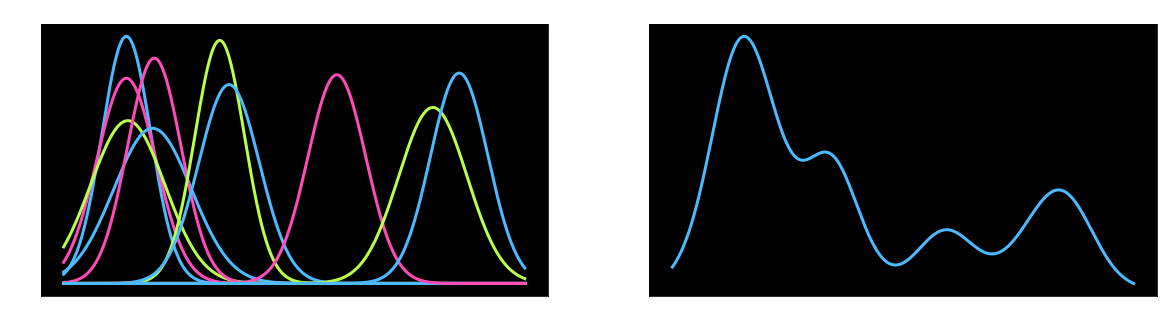

In [73]:
import scipy.stats as stats
means = [3]
stds = [1 + np.random.random()]
for i in range(sample_size):
    means.append(means[-1] + np.random.random() * (i/(sample_size/10.0)))
    stds.append(1 + np.random.random())
means = np.asarray(means)
stds = np.asarray(stds)
fig, axes = plt.subplots(1, 2)
x = np.linspace(means.min() - 1*stds.max() - 1, means.max() + 1*stds.max() + 1, 1000)
accumulation = np.zeros_like(x)
for i in range(sample_size):
    mu = means[i]
    sigma = stds[i]
    f = stats.norm.pdf(x, mu, sigma)
    accumulation += f
    axes[0].plot(x, f)
axes[0].set_title("10 Gaussian Distributions")
axes[1].plot(x, accumulation)
axes[1].set_title('Smooth Function = Sum of Gaussians')
plt.show()

# Interpretable Neural Networks

{% cite univ_approx_orig %} is the original paper suggesting NNs are a type of universal approximator. The theory of this contribution was explored in multi-layer perceptrons in {% cite pinkus_1999 %} and generally formalized by {% cite univ_approx_thm %}. The theorem can be summarized by:

> A neural network with a single hidden layer of infinite width can approximate any continuous function.

This theorem means that neural networks can be used to approximate the feature-wise non-linear, non-parametric, functions ($h_k$ in the previous section) necessary for Generalized Additive Models. Furthermore, neural networks fit via backpropogation can describe a wider set of functions than GAMs fit via backfitting and regularization. This is because continuous functions don't have to be smooth, while smooth functions have to be continuous.

In [9]:
#hide
# generate a piecewise function that is not smooth, but continuous
def two_f(x):
    return x ** 3
def one_f(x):
    return x ** 4 * 10
def zero_f(x):
    return x ** 5 * 100
def transform(prev_f,cur_f,transition):
    prev = prev_f(transition)
    cur = cur_f(transition)
    diff = prev - cur
    def new_f(x):
        return cur_f(x) + diff
    return new_f
one = transform(two_f, one_f, 2)
zero = transform(one, zero_f, 1)
def piecewise_crazy(x):
    x = abs(x)
    if x > 2:
        return two_f(x)
    elif x > 1:
        return one(x)
    else:
        return zero(x)

In [117]:
#hide
fnames = {
    'a': 'piecewise function',
   # 'b': r"$x^4 + x^3 - 10 * x^2 + x$",
    'b': 'periodic function'
}

In [79]:
#hide
#set up parameters to generate 3 normally distributed columns
columns = ['a','b']
size = 1000000
mean = 0.0
#set to 1.333 so that 3 stds is at around 4
std = 1.0
#create the dataset
data = {
    col: np.random.normal(
        size=size, loc=mean, scale=std
    ) for col in columns
}
df = pd.DataFrame(data)

def piecewise_abs(x):
    val = abs(x)
    dec = val % 1
    loc = int(x)
    if loc % 2 == 0:
        out = dec
    else:
        out = 1 - dec
    if out > 0.75:
        out = 0.75
    return (out * 10) ** 2
functions = {
    'a': lambda x: piecewise_crazy(x),
   # 'b': lambda x: x**4 + x**3 - 10 * x**2 + x,
    'b': lambda x: piecewise_abs(x),
}
for col in columns:
    df[f'{col}_transform'] = df[col].apply(functions[col])
#set up a prediction task where the target is a composition of
#    the nonlinear transforms, but the training data is the normally
#    distributed data prior to being transformed    
X = df[[c for c in df.columns if not c.endswith('_transform')]]
y = df[[c for c in df.columns if c.endswith('_transform')]].sum(1)
#X.assign(target=y).head()

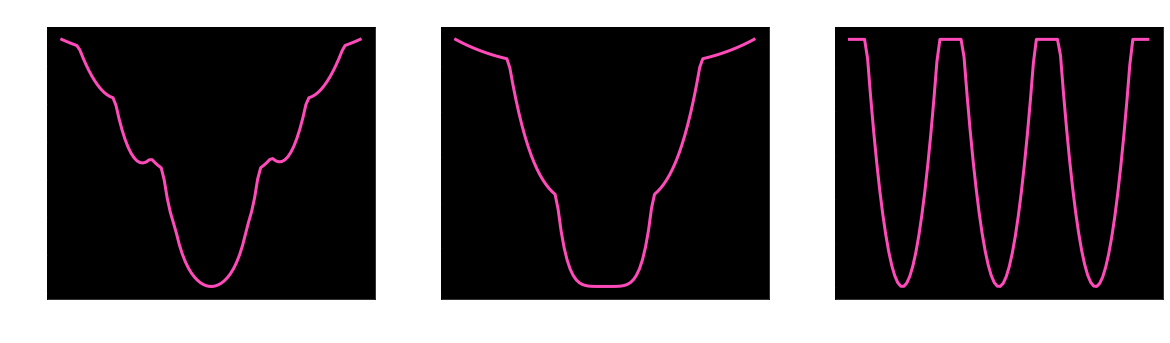

In [120]:
#hide_input
from mpl_toolkits.mplot3d import Axes3D
fig, axes = plt.subplots(1, len(X.columns) + 1)
features = [None for _ in X.columns]
output = None
for f_idx, column in enumerate(X.columns):
    ax = axes[f_idx + 1]
    start = np.quantile(df[column],0.999)
    end = np.quantile(df[column],0.001)
    test_x = np.expand_dims(np.linspace(start,end,100,dtype=np.float32),axis=1)
    function = functions[column]
    true_y = np.asarray([function(x[0]) for x in test_x])
    ax.plot(test_x, true_y, color=(1.0,75.0/255.0,186.0/255.0))
    ax.set_title(fnames[column], fontsize=18)
    features[f_idx] = test_x
    if output is None:
        output = true_y
    else:
        output += true_y
ax = axes[0]
ax.set_title('sum of feature functions',fontsize=18)
ax.set_xlabel('sum of input features', c='white')
ax.plot(features[0] + features[1], output, color=(1.0,75.0/255.0,186.0/255.0))
plt.show()

Above are images of three functions. The first two are piecewise continuous, but not smooth. The last function is a linear combination of the first two. We would like to build a model that can fit the last function, while maintaining feature-wise interpretability such that we can see that it properly learns the first two functions. Unfortunately, it is not reasonable to expect a GAM to fit the non-smooth functions. Below is a GAM with very very low regularization and smoothness penalties. Furthermore, it is trained and tested on the same dataset. This is a strong demonstration that GAMs cannot approach these problems, because they can't even overfit to the solution.

In [81]:
from pygam import LinearGAM
from pygam import s as spline
#fit a classic GAM with no regularization or smoothing penalties to try and 
#let it overfit to non-smooth functions. It still fails!
gam = LinearGAM(
    spline(0,lam=0,penalties=None) + 
    spline(1,lam=0,penalties=None),
    callbacks=[]
).fit(X, y)

In [82]:
#hide
mae = tf.keras.metrics.MeanAbsoluteError()
mse = tf.keras.metrics.MeanSquaredError()
yhat = gam.predict(X)

In [84]:
#hide
print('mean squared error:',round(mse(yhat, y).numpy(),3),'\nmean absolute error:',round(mae(yhat, y).numpy(),3))

mean squared error: 82.669 
mean absolute error: 7.008


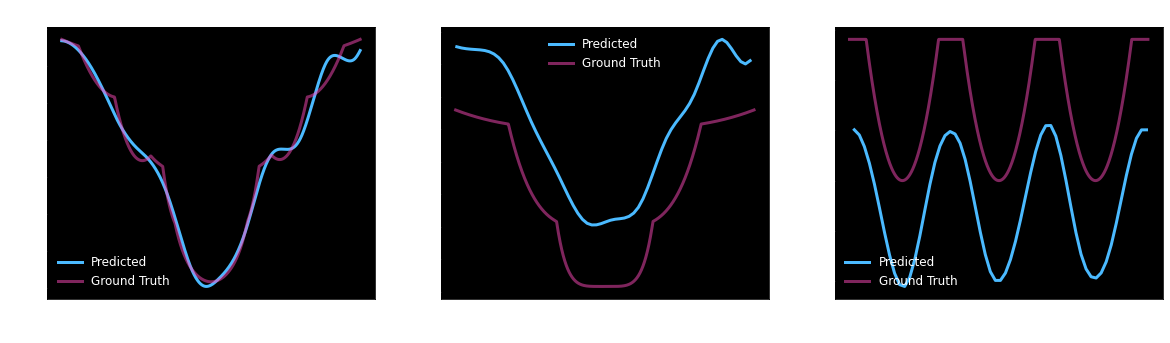

In [130]:
#hide_input
fig, axes = plt.subplots(1, len(X.columns) + 1, figsize=(20,5))
features = [None for _ in X.columns]
output_true = None
output_pred = None
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    f_idx = i - 1
    column = columns[i]
    ax = axes[i + 1] #works because intercept is always last term
    start = np.quantile(df[column],0.001)
    end = np.quantile(df[column],0.999)
    test_x = np.expand_dims(np.linspace(start,end,1000,dtype=np.float32),axis=1)
    function = functions[column]
    true_y = np.asarray([function(x[0]) for x in test_x])
    XX = gam.generate_X_grid(term=i)
    XX = XX[np.where((XX[:,i] > start) & (XX[:,i] < end))[0],:]
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    ax.plot(XX[:, term.feature], pdep, label='Predicted')
    ax.plot(test_x, true_y, label="Ground Truth", alpha=0.5)
    ax.set_title(fnames[column], fontsize=18)
    ax.legend()
    features[f_idx] = test_x
    if output_true is None:
        output_true = true_y
        output_pred = pred_y
    else:
        output_true += true_y
        output_pred += pred_y
ax = axes[0]
ax.plot(features[0] + features[1], gam.predict(np.concatenate(features,axis=1)), label='Predicted')
ax.plot(features[0] + features[1], output_true, alpha=0.5, label='Ground Truth')
ax.set_title('sum of feature functions',fontsize=18)
ax.set_xlabel('sum of input features', c='white')
ax.legend()
plt.show()

While these fits aren't terrible in terms of prediction error, that's not what we care about. We care about learning the proper structure for the functions that explain the relationship between individual features and our output. The above plots are a clear demonstration that GAMs can't even overfit to provide that.

Luckily, because these functions are continuous, we can use a neural network to approximate them!

## Generalized Additive Neural Networks (GANNs)

The trick is to use a different neural network for each individual feature, and add them together just like how GAMs work! By replacing the non-linear, non-parametric, functions in GAMs by neural networks, we get get Generalized Additive Neural Networks (GANNs), introduced in {% cite GANN %}. Unfortunately, this contribution did not take off because we didn't have the technical capacity to train large networks as we do today. Luckily, now it is quite easy to fit such a model.

![](https://ryansaxe.com/images/nam.png)

GANNs are simply a linear combination of neural networks, where each network only observes a single input feature{% fn 7%}. Because each of these networks take a single input feature, and provide a single output feature, it becomes possible to plot a two-dimensional graph where the x-axis is the input feature and the y-axis is the output feature for each network. This graph is hence a fully transparent function describing how the neural network learned to transform the input feature as it contributes, additively, to the prediction. Hence this type of neural architecture is sufficient for creating a model as transparent as the linear models described in this blog postso far.

Below is code for creating a GANN using [Keras](https://www.keras.io). As you can see, this model is capable of solving the regression problem while maintaining feature-wise transparency on piecewise continous functions!

In [87]:
from tensorflow.keras import layers, regularizers

#define a simple multi-layer perceptron
class NN(tf.keras.Model):
    def __init__(
        self,
        name=None
    ):
        super().__init__(name=name)
        # relu helps learn more jagged functions if necessary.
        self.l1 = layers.Dense(8, activation='relu')
        # softplus helps smooth between the jagged areas from above
        #     as softplus is referred to as "SmoothRELU"
        self.l2 = layers.Dense(8, activation='softplus')
        self.l3 = layers.Dense(8, activation='softplus')
        self.l4 = layers.Dense(8, activation='softplus')
        self.output_layer = layers.Dense(1)
    
    def call(self, x, training=None):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        return self.output_layer(x)
    
#define a Generalized Additive Neural Network for n features
class GANN(tf.keras.Model):
    def __init__(
        self,
        n_features,
        name=None
    ):
        super().__init__(name=name)
        self.n_features = n_features
        # initialize MLP for each input feature
        self.components = [NN() for i in range(n_features)]
        # create final layer for a linear combination of learned components
        self.linear_combination = tf.keras.layers.Dense(1)
    
    @tf.function
    def call(self, x, training=None):
        #split up by individual features
        individual_features = tf.split(x, self.n_features, axis=1)
        components = []
        #apply the proper MLP to each individual feature
        for f_idx,individual_feature in enumerate(individual_features):
            component = self.components[f_idx](individual_feature)
            components.append(component)
        #concatenate learned components and return linear combination of them
        components = tf.concat(components, axis=1)
        return self.linear_combination(components)

In [88]:
#hide_output
model = GANN(n_features=2)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)
hist = model.fit(
    X.to_numpy(),
    y.to_numpy(),
    epochs=50,
    batch_size=32,
)

Train on 1000000 samples
Epoch 1/50
1000000/1000000 [==============================] - 51s 51us/sample - loss: 476.0538 - mean_absolute_error: 10.6678
Epoch 2/50
1000000/1000000 [==============================] - 56s 56us/sample - loss: 37.2426 - mean_absolute_error: 4.1555
Epoch 3/50
1000000/1000000 [==============================] - 58s 58us/sample - loss: 21.6574 - mean_absolute_error: 3.2734
Epoch 4/50
1000000/1000000 [==============================] - 58s 58us/sample - loss: 5.1283 - mean_absolute_error: 1.5393
Epoch 5/50
1000000/1000000 [==============================] - 58s 58us/sample - loss: 3.2277 - mean_absolute_error: 1.1293
Epoch 6/50
1000000/1000000 [==============================] - 59s 59us/sample - loss: 2.5505 - mean_absolute_error: 0.9687
Epoch 7/50
1000000/1000000 [==============================] - 59s 59us/sample - loss: 2.2894 - mean_absolute_error: 0.9239
Epoch 8/50
1000000/1000000 [==============================] - 58s 58us/sample - loss: 2.0061 - mean_absolute_

In [89]:
#hide
print('mean squared error:',round(hist.history['loss'][-1],3),'\nmean absolute error:',round(hist.history['mean_absolute_error'][-1],3))

mean squared error: 0.798 
mean absolute error: 0.367


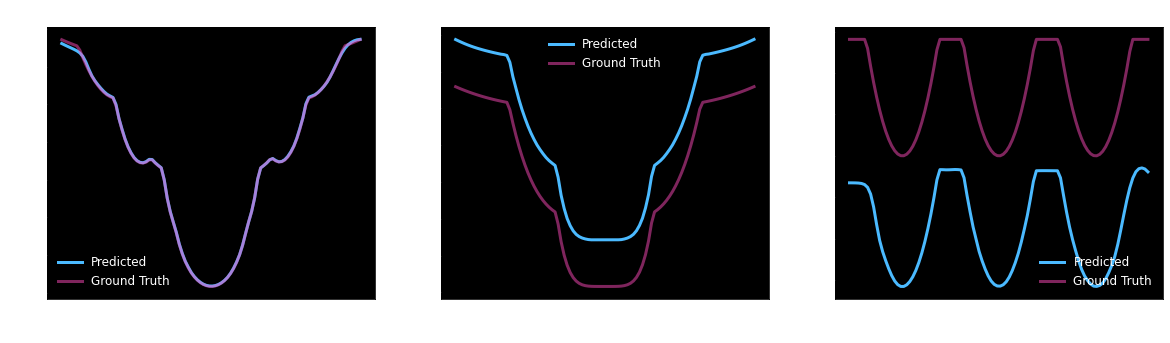

In [125]:
#hide_input
fig, axes = plt.subplots(1, len(X.columns) + 1, figsize=(20,5))
features = [None for _ in X.columns]
output_true = None
output_pred = None
for f_idx, column in enumerate(X.columns):
    ax = axes[f_idx + 1]
    multiplier = model.linear_combination.weights[0].numpy()[f_idx]
    start = np.quantile(df[column],0.999)
    end = np.quantile(df[column],0.001)
    test_x = np.expand_dims(np.linspace(start,end,100,dtype=np.float32),axis=1)
    function = functions[column]
    true_y = np.asarray([function(x[0]) for x in test_x])
    pred_y = model.components[f_idx](test_x).numpy() * multiplier
    ax.plot(test_x, pred_y, label='Predicted')
    ax.plot(test_x, true_y, label='Ground Truth', alpha=0.5)
    ax.set_title(fnames[column], fontsize=18)
    ax.legend()
    features[f_idx] = test_x
    if output_true is None:
        output_true = true_y
        output_pred = pred_y
    else:
        output_true += true_y
        output_pred += pred_y
ax = axes[0]
ax.plot(features[0] + features[1], output_pred, label='Predicted')
ax.plot(features[0] + features[1], output_true, alpha=0.5, label='Ground Truth')
ax.set_title('sum of feature functions',fontsize=18)
ax.set_xlabel('sum of input features', c='white')
ax.legend()
plt.show()

At first glance, these results look good, but not perfect. The right-most-plot demonstrates this model achieved a near perfect fit of the actual task, while the first two plots look like the Neural Additive Model was capable of learning the general shapes of the functions, but is off on the intercepts for all of them. This should not discount the validity of the model. The corresponding math demonstrates perfectly fitting intercepts of an additive model cannot be guaranteed.

Let $h_i(X_i) = \alpha_i + f(X_i)$ where $f(X_i)$ represents all of the aspects of $h(X_i)$ that dependent on $X_i$, and $\alpha_i$ represents the intercept.

$$
\begin{aligned}
y & = \beta_0 + \sum_{i=1}^n \beta_i h_i(X_i) \\
& = \beta_0 + \sum_{i=1}^n \beta_i (\alpha_i + f_i(X_i)) \\
& = \beta_0 + \sum_{i=1}^n \beta_i \alpha_i + \sum_{i=1}^n \beta_i f_i(X_i)
\end{aligned}
$$

The only way to tease apart these intercepts is via $\beta$. Imagine the proper fit of this equation, for every $i$, had $\beta_i = 1$ and $\alpha_i = 2$. In this case, if half of the learned $\alpha_i$s are zero, and the other half are four, that would yield the exact same result for $\sum_{i=1}^n \beta_i \alpha_i$ as the proper fit. Hence, by way of contradictory example, it is impossible to guarantee learning correct intercepts for the individual components of any additive model. 

The plots below are what happens when we simply adjust the learned intercepts for these functions. As you can see, by simply changing the intercept, we are able to show a near perfect fit of these functions, which is the best we can ever hope to do!

In [92]:
#hide
def dxdy(x, y):
    return (x[1:] - x[:-1])/(y[1:] - y[:-1])

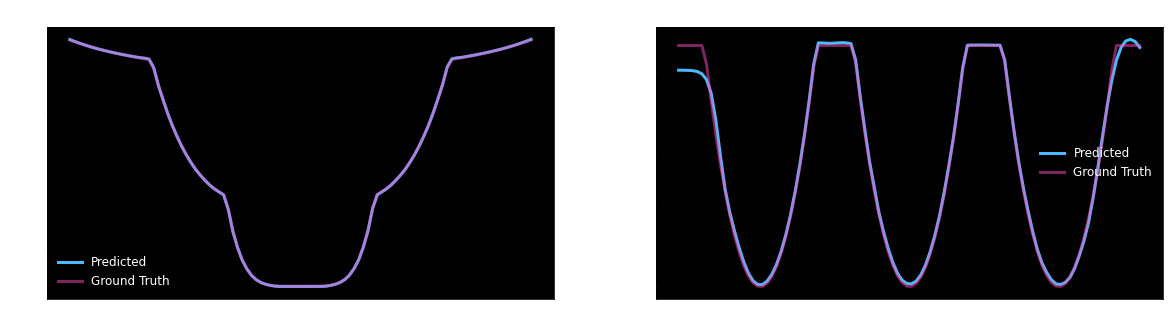

In [131]:
#hide_input
fig, axes = plt.subplots(1, len(X.columns), figsize=(20,5))
#fig2, axes2 = plt.subplots(1, len(X.columns), figsize=(20,5))
for f_idx, column in enumerate(X.columns):
    ax = axes[f_idx]
    multiplier = model.linear_combination.weights[0].numpy()[f_idx]
    start = np.quantile(df[column],0.999)
    end = np.quantile(df[column],0.001)
    test_x = np.expand_dims(np.linspace(start,end,100,dtype=np.float32),axis=1)
    function = functions[column]
    true_y = np.asarray([function(x[0]) for x in test_x])
    pred_y = model.components[f_idx](test_x).numpy() * multiplier
    mean_diff = np.average(true_y - pred_y)
    ax.plot(test_x, pred_y + mean_diff, label='Predicted')
    ax.plot(test_x, np.expand_dims(true_y, axis=1), label='Ground Truth',alpha=0.5)
    title = '' + fnames[column] 
    ax.set_title(title, fontsize=18)
    ax.legend()
plt.show()

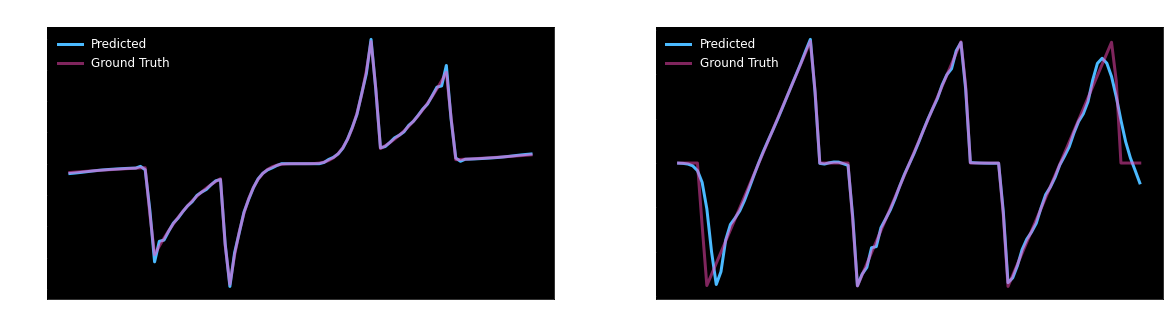

In [127]:
#hide
fig, axes = plt.subplots(1, len(X.columns), figsize=(20,5))
#fig2, axes2 = plt.subplots(1, len(X.columns), figsize=(20,5))
for f_idx, column in enumerate(X.columns):
    ax = axes[f_idx]
    multiplier = model.linear_combination.weights[0].numpy()[f_idx]
    start = np.quantile(df[column],0.999)
    end = np.quantile(df[column],0.001)
    test_x = np.expand_dims(np.linspace(start,end,100,dtype=np.float32),axis=1)
    function = functions[column]
    true_y = np.asarray([function(x[0]) for x in test_x])
    pred_y = model.components[f_idx](test_x).numpy() * multiplier
    ax.plot(test_x[1:], dxdy(pred_y,test_x), label='Predicted')
    ax.plot(test_x[1:], dxdy(np.expand_dims(true_y, axis=1),test_x), label='Ground Truth',alpha=0.5)
    title = 'derivative of ' + fnames[column] 
    ax.set_title(title, fontsize=18)
    ax.legend()
plt.show()

This is a clear deomonstration that Generalized Additive Neural Networks are capable of overfitting to piecewise continuous functions while maintaining transparency! 

However, this is still just a toy example. The next section delves into Neural Additive Models (NAMs), which are a special variant of GANNs that are designed to be able to fit "jumpy functions", as this is more reminiscient of real-world data.

## Neural Additive Models (NAMs)

{% cite nam_2020 %}

## Generalizing the Computational Graph

This is the fun part. This is where all your creativity can yield an extremely flexible, powerful, and interpretable model! The world is your oyster, and you can use your understanding of neural networks and additive models to design an architecture that accomplishes your goals.

<div class="fake-header h2">References</div>
{% bibliography --cited %}

<div class="fake-header h2">Footnotes</div>
<ol class='footnotes'>

{{ "the nuances of fitting these models (e.g. Maximum Likelihood Estimation, Backfitting, Gradient Descent) are not covered in detail in this blog post. There are links to papers and lectures on these topics in their corresponding sections if you would like to read about them." | fndetail: 1}}

{{ "The closed form solution for OLS is $\beta = (X^TX)^\inv X^Ty$. This requires $X^TX$ to be invertible, which is the case when the elements in $X$ are linearly independent. This is satisfied by our assumption of independence. Without this assumption, there is no closed form solution, and $\beta$ can be approximated by the maximum likelihood estimation function: $min_\beta(y - \beta X)^T(y - \beta X)$." | fndetail: 2 }}

{{ 'The exponential family is a particular family of probability distributions such that their probability density function (PDF) can be writted as: $P(x | \theta) = f(x) g(\theta) exp \Big( \eta(\theta) \centerdot T(x) \Big)$, where $f$, $g$, $\eta$, and $T$ are known functions and $\theta \in \Reals$ is the only parameter to the PDF.' | fndetail: 3 }}

{{ 'This explains why we could create a model identical to linear and logistic regression by designing a neural network with zero hidden layers.' | fndetail: 4 }}

{{ 'I chose to use gaussians here for a couple reasons. First, {% cite bspline_gauss %} demonstrates that a cubic b-spline can very closely approximate a gaussian. Second, it's likely something more readers are familiar with than splines, and so I think it's a better example'  | fndetail: 5 }}

{{ 'The "smoothness" of a function is described by the continuity of the derivatives. The set of functions with a smoothness of 0 is equivalent to the set of continuous functions. The set of functions with a smoothness of 1 is the set of continuous functions such that their first derivative is continuous. So on, and so forth. Generally, a function is considered "smooth" if it has "smoothness" of $\infty$. In other words, it is infinitely differentiable.' | fndetail: 6 }}

{{ 'Technically, this could be fit where the sub-networks take more than a single feature as input, but this comes at a cost of interpretability. It is still possible to explore the relationship between both features and the output, however it becomes high-dimensional, entangled, and hence more difficult to interpret.' | fndetail: 7 }}
</ol>